<img src="../../images/qiskit-heading.gif" alt="Note: In order for images to show up in this jupyter notebook you need to select File => Trusted Notebook" width="500 px" align="left">

# _*QISKit ACQUA Chemistry: Experimenting with molecolar ground state energy with variational quantum eigensolver*_ 

The latest version of this notebook is available on https://github.com/QISKit/qiskit-tutorial.

***
### Contributors
Antonio Mezzacapo, Richard Chen, Marco Pistoia, Shaohan Hu, Peng Liu, Stephen Wood, Jay Gambetta

### Introduction

One of the most compelling possibilities of quantum computation is the the simulation of other quantum systems. Quantum simulation of quantum systems encompasses a wide range of tasks, including most significantly:
    
1. Simulation of the time evolution of quantum systems.

2. Computation of ground state properties. 

These applications are especially useful when considering systems of interacting fermions, such as molecules and strongly correlated materials. The computation of ground state properties of fermionic systems is the starting point for mapping out the phase diagram of condensed matter Hamiltonians. It also gives access to the key question of electronic structure problems in quantum chemistry - namely, reaction rates. The focus of this notebook is on molecular systems, which are considered to be the ideal bench test for early-stage quantum computers, due to their relevance in chemical applications despite relatively modest sizes. Formally, the ground state problem asks the following:

For some physical Hamiltonian *H*, find the smallest eigenvalue $E_G$, such that $H|\psi_G\rangle=E_G|\psi_G\rangle$, where $|\Psi_G\rangle$ is the eigenvector corresponding to $E_G$.
    
It is known that in general this problem is intractable, even on a quantum computer. This means that we cannot expect an efficient quantum algorithm that prepares the ground state of general local Hamiltonians. Despite this limitation, for specific Hamiltonians of interest it might be possible, given physical constraints on the interactions, to solve the above problem efficiently. Currently, at least four different methods exist to approach this problem:

1. Quantum phase estimation: Assuming that we can approximately prepare the state $|\psi_G\rangle$, this routine uses controlled implementations of the Hamiltonian to find its smallest eigenvalue. 
2. Adiabatic theorem of quantum mechanics: The quantum system is adiabatically dragged from being the ground state of a trivial Hamiltonian to the one of the target problem, via slow modulation of the Hamiltonian terms. 
3. Dissipative (non-unitary) quantum operation: The ground state of the target system is a fixed point. The non-trivial assumption here is the implementation of the dissipation map on quantum hardware. 
4. Variational quantum eigensolvers: Here we assume that the ground state can be represented by a parameterization containing a relatively small number of parameters.

In this notebook we focus on the last method, as this is most likely the simplest to be realized on near-term devices. 

The general idea is to define a parameterization $|\psi(\boldsymbol\theta)\rangle$ of quantum states, and minimize the energy 

$$E(\boldsymbol\theta) = \langle \psi(\boldsymbol\theta)| H |\psi(\boldsymbol\theta)\rangle,$$ 

The key ansatz is that the number of parameters $|\boldsymbol\theta^*|$ that minimizes the energy function scales polynomially with the size (e.g., number of qubits) of the target problem.  

Then, any local fermionic Hamiltonian can be mapped into a sum over Pauli operators $P_i$,  

$$H\rightarrow H_P = \sum_i^M w_i P_i,$$ 

and the energy corresponding to the state $|\psi(\boldsymbol\theta\rangle$, $E(\boldsymbol\theta)$, can be estimated by sampling the individual Pauli terms $P_i$ (or sets of them that can be measured at the same time) on a quantum computer: 

$$E(\boldsymbol\theta) = \sum_i^M w_i \langle \psi(\boldsymbol\theta)| P_i |\psi(\boldsymbol\theta)\rangle.$$ 

Last, some optimization technique must be devised in order to find the optimal value of parameters $\boldsymbol\theta^*$, such that $|\psi(\boldsymbol\theta^*)\rangle\equiv|\psi_G\rangle$.



### Fermionic Hamiltonians

The Hamiltonians describing systems of interacting fermions can be expressed in second quantization language, considering fermionic creation (annihilation) operators $a^\dagger_\alpha(a_\alpha)$, relative to the $\alpha$-th fermionic mode. In the case of molecules, the $\alpha$ labels stand for the different atomic or molecular orbitals. Within the second-quantization framework, a generic molecular Hamiltonian with $M$ orbitals can be written as 
$$H =H_1+H_2=\sum_{\alpha, \beta=0}^{M-1} t_{\alpha \beta} \, a^\dagger_{\alpha} a_{\beta} +\frac{1}{2}  \sum_{\alpha, \beta, \gamma, \delta = 0}^{M-1} u_{\alpha \beta \gamma \delta}\, a^\dagger_{\alpha} a^\dagger_{\gamma} a_{\delta} a_{\beta},$$
with the one-body terms representing the kinetic energy of the electrons and the potential energy that they experience in the presence of the nuclei, 
$$ t_{\alpha\beta}=\int d\boldsymbol x_1\Psi_\alpha(\boldsymbol{x}_1) \left(-\frac{\boldsymbol\nabla_1^2}{2}+\sum_{i} \frac{Z_i}{|\boldsymbol{r}_{1i}|}\right)\Psi_\beta (\boldsymbol{x}_1),$$
and their interactions via Coulomb forces 
$$ u_{\alpha\beta\gamma\delta}=\int\int d \boldsymbol{x}_1 d \boldsymbol{x}_2 \Psi_\alpha^*(\boldsymbol{x}_1)\Psi_\beta(\boldsymbol{x}_1)\frac{1}{|\boldsymbol{r}_{12}|}\Psi_\gamma^*(\boldsymbol{x}_2)\Psi_\delta(\boldsymbol{x}_2),$$
where we have defined the nuclei charges $Z_i$, the nuclei-electron and electron-electron separations $\boldsymbol{r}_{1i}$ and $\boldsymbol{r}_{12}$, the $\alpha$-th orbital wavefunction $\Psi_\alpha(\boldsymbol{x}_1)$, and we have assumed that the spin is conserved in the spin-orbital indices $\alpha,\beta$ and $\alpha,\beta,\gamma,\delta$.

### Molecules considered in this notebook and mapping to qubits

We consider in this notebook the optimization of two potential energy surfaces, for the hydrogen and lithium hydride molecules, obtained using the STO-3G basis. The molecular Hamiltonians are computed as a function of their interatomic distance, then mapped to two-(H$_2$) and four-(LiH$_2$) qubit problems, via elimination of core and high-energy orbitals and removal of $Z_2$ symmetries.

### Approximate universal quantum computing for quantum chemisty problems

In order to find the optimal parameters $\boldsymbol\theta^*$, we set up a closed optimization loop with a quantum computer, based on some stochastic optimization routine. Our choice for the variational ansatz is a deformation of the one used for the optimization of classical combinatorial problems, with the inclusion of $Z$ rotation together with the $Y$ ones. The optimization algorithm for fermionic Hamiltonians is similar to the one for combinatorial problems, and can be summarized as follows: 


1. Map the fermionic Hamiltonian $H$ to a qubit Hamiltonian $H_P$.
2. Choose the maximum depth of the quantum circuit (this could be done adaptively).
3. Choose a set of controls $\boldsymbol\theta$ and make a trial function $|\psi(\boldsymbol\theta)\rangle$. The difference with the combinatorial problems is the insertion of additional parametrized $Z$ single-qubit rotations.
4. Evaluate the energy $E(\boldsymbol\theta) = \langle\psi(\boldsymbol\theta)~|H_P|~\psi(\boldsymbol\theta)\rangle$ by sampling each Pauli term individually, or sets of Pauli terms that can be measured in the same tensor product basis.
5. Use a classical optimizer to choose a new set of controls.
6. Continue until the energy has converged, hopefully close to the real solution $\boldsymbol\theta^*$, and return the last value of $E(\boldsymbol\theta)$.
    

Note that, as opposed to the classical case, in the case of a quantum chemistry Hamiltonian one has to sample over non-computational states that are superpositions, and therefore take advantage of using a quantum computer in the sampling part of the algorithm. Motivated by the quantum nature of the answer, we also define a variational trial ansatz in this way: 

$$|\psi(\boldsymbol\theta)\rangle  = [U_\mathrm{single}(\boldsymbol\theta) U_\mathrm{entangler}]^m |+\rangle$$

where $U_\mathrm{entangler}$ is a collection of cPhase gates (fully entangling gates), $U_\mathrm{single}(\boldsymbol\theta) = \prod_{i=1}^n Y(\theta_{i})Z(\theta_{n+i})$ are single-qubit $Y$ and $Z$ rotation, $n$ is the number of qubits and $m$ is the depth of the quantum circuit. 



References and additional details:

[1] A. Kandala, A. Mezzacapo, K. Temme, M. Takita, M. Brink, J. M. Chow, and J. M. Gambetta, *Hardware-efficient Variational Quantum Eigensolver for Small Molecules and Quantum Magnets*, Nature 549, 242 (2017), and references therein.


In [1]:
# useful additional packages 
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

from qiskit_acqua_chemistry import ACQUAChemistry
import warnings
warnings.filterwarnings('ignore')

import logging
logger = logging.getLogger()
# logger.setLevel(logging.DEBUG) # uncomment it to see detailed logging

In [2]:
################# import Qconfig and set APIToken and API url and  prepare backends ############
try:
    import sys
    sys.path.append("../../") # go to parent dir
    import Qconfig
except Exception as e:
    print(e)
    print("Please ")
    
from qiskit import register, available_backends

#set api
APItoken=Qconfig.APItoken
url = Qconfig.config.get('url', None)
hub = Qconfig.config.get('hub', None)
group = Qconfig.config.get('group', None)
project = Qconfig.config.get('project', None)
try:
    register(APItoken, url, hub, group, project)
except Exception as e:
    print(e)

print("Backends: {}".format(available_backends()))

Backends: ['local_qasm_simulator', 'local_statevector_simulator', 'ibmqx2', 'local_clifford_simulator', 'ibmqx5', 'ibmq_qasm_simulator', 'local_unitary_simulator', 'ibmqx4']


## Optimization of H$_2$ at bond length

In this first part of the notebook we show the optimization of the H$_2$ Hamiltonian in the STO-3G basis at the bond length of 0.735 Angstrom. After mapping it to a four-qubit system with a parity transformation, two spin-parity symmetries are modded out, leading to a two-qubit Hamiltonian. The energy of the mapped Hamiltonian obtained is then minimized using the variational ansatz described in the introduction, and a stochastic perturbation simultaneous approximation (SPSA) gradient descent method. We stored the precomputed one- and two-body intergals and other molecular information in the hdf5 file.

In [3]:
# First, we use classical eigendecomposition to get ground state energy (including nuclear repulsion energy) as reference.
acqua_chemistry_dict = {
    'driver': {'name': 'HDF5'},
    'HDF5': {'hdf5_input': 'H2/H2_equilibrium_0.735_sto-3g.hdf5'},
    'operator': {'name':'hamiltonian', 
                 'qubit_mapping': 'parity', 
                 'two_qubit_reduction': True},
    'algorithm': {'name': 'ExactEigensolver'}
}
solver = ACQUAChemistry()
result = solver.run(acqua_chemistry_dict)
print('Ground state energy (classical): {:.12f}'.format(result['energy']))

# Second, we use variational quantum eigensolver (VQE)
acqua_chemistry_dict['algorithm']['name'] = 'VQE'
acqua_chemistry_dict['optimizer'] = {'name': 'SPSA', 'max_trials': 350}
acqua_chemistry_dict['variational_form'] = {'name': 'RYRZ', 'depth': 3, 'entanglement':'full'}
acqua_chemistry_dict['backend'] = {'name': 'local_statevector_simulator'}

solver = ACQUAChemistry()
result = solver.run(acqua_chemistry_dict)
print('Ground state energy (quantum)  : {:.12f}'.format(result['energy']))
print("====================================================")
# You can also print out other info in the field 'printable'
for line in result['printable']:
    print(line)

Ground state energy (classical): -1.137306035753
Ground state energy (quantum)  : -1.137300505133
* Electronic ground state energy: -1.8572694964119836
  - computed part:      -1.8572694964119836
  - frozen energy part: 0.0
  - particle hole part: 0.0
~ Nuclear repulsion energy: 0.7199689912789116
> Total ground state energy: -1.137300505133072
  Measured:: Num particles: 2.000, S: 0.000, M: 0.00000
* Electronic dipole moment: [ 0.          0.         -0.00158764]
  - computed part:      [ 0.          0.         -0.00158764]
  - frozen energy part: [0. 0. 0.]
  - particle hole part: [0. 0. 0.]
~ Nuclear dipole moment: [0. 0. 0.]
> Dipole moment: [ 0.          0.         -0.00158764]  Total: 0.0015876375062169954


## Optimizing the potential energy surface 

The optimization considered previously is now performed for two molecules, H$_2$ and LiH, for different interatomic distances, and the correspoding nuclei Coulomb repulsion is added in order to obtain a potential energy surface. 

In [4]:
molecule='H2' # name of the molecule: options are "H2" or "LiH"

solver = ACQUAChemistry()
acqua_chemistry_dict = {
    'driver': {'name': 'HDF5'},
    'HDF5': {'hdf5_input': ''},
    'operator': {'name':'hamiltonian', 
                 'qubit_mapping': 'parity', 
                 'two_qubit_reduction': True},
    'algorithm': {'name': ''},
    'optimizer': {'name': 'SPSA', 'max_trials': 350},
    'variational_form': {'name': 'RYRZ', 'depth': 3, 'entanglement':'full'}
}

backend = {'name': 'local_statevector_simulator'}
# backend = {'name': 'local_qasm_simulator', 'shots': 1024} # uncomment it to simulate with shot noise
algos = ['ExactEigensolver', 'VQE']

if molecule == 'LiH':
    mol_distances = np.arange(0.6, 5.1, 0.1)
    acqua_chemistry_dict['operator']['freeze_core'] = True
    acqua_chemistry_dict['operator']['orbital_reduction'] = [-3, -2]
    acqua_chemistry_dict['optimizer']['max_trials'] = 2500
    acqua_chemistry_dict['variational_form']['depth'] = 5
else:
    mol_distances = np.arange(0.2, 4.1, 0.1)

energy = np.zeros((len(algos), len(mol_distances)))

for j, algo in enumerate(algos):
    acqua_chemistry_dict['algorithm']['name'] = algo
    if algo == 'ExactEigensolver':
        acqua_chemistry_dict.pop('backend', None)
    elif algo == 'VQE':
        acqua_chemistry_dict['backend'] = backend
    print("Solving with {}".format(algo))
    for i, dis in enumerate(mol_distances):
        print("Processing atomic distance: {:1.1f} Angstrom".format(dis), end='\r')
        acqua_chemistry_dict['HDF5']['hdf5_input'] = "{}/{:1.1f}_sto-3g.hdf5".format(molecule, dis)
        result = solver.run(acqua_chemistry_dict)
        energy[j][i] = result['energy']
    print("\n")

Solving with ExactEigensolver
Processing atomic distance: 4.0 Angstrom

Solving with VQE
Processing atomic distance: 4.0 Angstrom



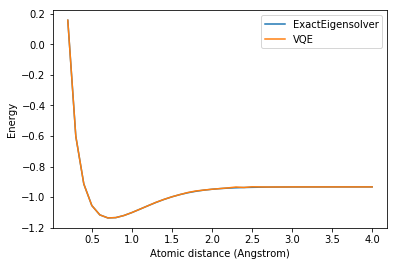

In [5]:
for i, algo in enumerate(algos):
    plt.plot(mol_distances, energy[i], label=algo)
plt.xlabel('Atomic distance (Angstrom)')
plt.ylabel('Energy')
plt.legend()
plt.show()